<a target="_blank" href="https://colab.research.google.com/github/davalpez/MyKaggle/blob/MyKaggle/Tensorflow%20basics/TF-classifiers.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Creating a Neural Network for Classification problems

In this notebook we are going to use different machine learning techniques and neural networks to effectively learn patterns from data we have labeled with certain characteristic and so, trying to identify patterns that could be not easily visible or speeding up the classification of certain data that contains a large number of parameters.

## Defining the problem

This time, the job for our NN is to help is figure out which group does some individual element belongs to based on its own characteristics as well as the group based on the similarities that the group represents.

Let's start simple and create some data to visualize better what we can do and how can we train a model to achieve this task. I find helpful for these experiments to use some datasets that scikit provides. In this case, I will use the function [make_moons()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [105]:
import sklearn as sk

In [106]:
from sklearn import datasets

n_samples = 500
seed = 30
X, y = sk.datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = sk.datasets.make_blobs(n_samples=n_samples, random_state=seed)


In [107]:
print(" X values: ",X[:5],", Y values :",y[:5])

 X values:  [[ 1.04504079  0.18983372]
 [-1.01867246  0.14786146]
 [ 0.23482704  1.05036349]
 [ 0.01692948  0.26916982]
 [ 0.97821768  0.19139193]] , Y values : [0 0 0 1 0]


Lets put it on a table and represent to see what kind of data are we experimenting now.

In [108]:
import pandas as pd

table_data = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
table_data


,X0,X1,label
0,1.045041,0.189834,0
1,-1.018672,0.147861,0
2,0.234827,1.050363,0
3,0.016929,0.269170,1
4,0.978218,0.191392,0
...,...,...,...
495,-0.244159,1.009570,0
496,0.194925,-0.104697,1
497,1.631648,-0.282787,1
498,1.466756,-0.378222,1


In [109]:
table_data.label.value_counts()

0    250
1    250
Name: label, dtype: int64

We have two types of label and a even distribution of both of them. We can have a better view of it by plotting it:

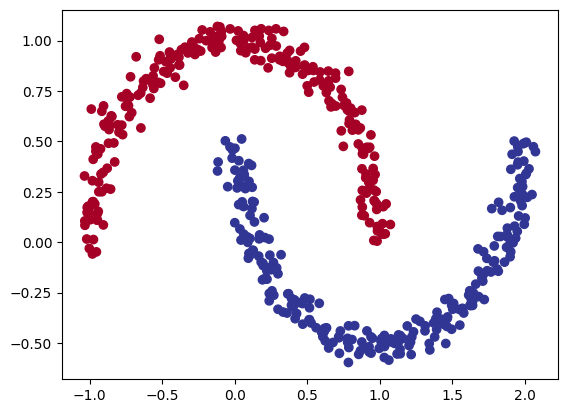

In [110]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

As we only have two groups in this example, we are experimenting with a binary classification problem. We will show later on a multiclass classification problem.

Let's remember that the last step for data preparation is to separate train data and test data :

In [111]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=0)

## Creating the classification model

As we went through in the other document for creating the architecture of a NN model for a regression problem, we follow the same principles for creating a NN architecture for a classification problem.

The steps if we remember are :


1.  **Create a model**, where we decide the size, number and type of the layers.

2.  **Compile the model**, where we define the loss function, we choose the optimizer and decide the metrics we use to evaluate our model.

3.  **Fit the model**, where we adjust the trainning data to our model and examinate how the model interacts and learns with that data.

We have certain aspects of our architecture we can modify and is where we can thrive to make our model more efficient and help us perform better with our tasks. To remember, these are the hyperparameters we can modify to build and enhance our NN.

**Take a look** that this time, we are specifing other characteristics speficially for our `loss function`. When in regression we use `MSE`or `MAE`, for classification we prefer to use [`Cross-entropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy).

 **Hyperparameter**      | **Description**                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **Input Layer**          | First layer of the network; defines the input shape based on the data features. |
| **Hidden Layer(s)**      | Intermediate layers between input and output; capture patterns in the data.     |
| **Units per Layer**      | Number of neurons in each hidden layer; determines the capacity of the layer.   |
| **Output Layer**         | Final layer of the network; outputs predictions in the desired format.          |
| **Hidden Activation**    | Function applied in hidden layers to introduce non-linearity (e.g., ReLU, Tanh).|
| **Output Activation**    | Function applied to the output layer (e.g., Softmax for classification).        |
| **Loss Function**        | Metric used to compute error for optimization (e.g., MSE, Cross-Entropy).       |
| **Optimizer**            | Algorithm used to update weights (e.g., SGD, Adam).                            |
|**Number of Epochs**      | Total number of complete passes through the training dataset during training.|



To create our NN, we will use the Tensorflow library.

In [112]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.16.2


Let's do a very basic model first

In [113]:
# Basic model 1

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_1 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(1)]
)

# 2. Compile the model.

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model.

history = model_1.fit(train_features, train_label, epochs=100, verbose=0)

Let's see how the learning curve looks for a very simple classification model

In [114]:
def build_hist_table(history):
    history_table = pd.DataFrame(history.history)
    history_table['epoch'] = history.epoch
    return history_table

history_table_1 = build_hist_table(history)
history_table_1.tail()

,accuracy,loss,epoch
95,0.88,0.234785,95
96,0.88,0.234769,96
97,0.88,0.234753,97
98,0.88,0.234745,98
99,0.88,0.234734,99


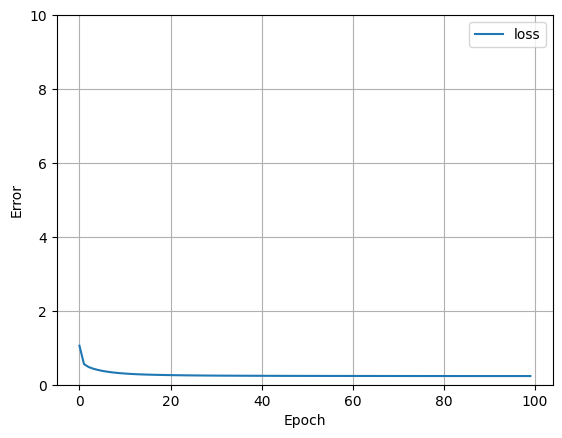

In [115]:
def plot_loss(history,range):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim(range)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history,[0,10])

### Visualize how or model classifies

We can see the limitations of the simplicity of this model and it can't reduce the loss after the first epochs. Let's see first what is our NN doing here and interpret what the classification layer is doing to determine wether a point in this dataset is labeled as group 0 or group 1.

Taking inspiration on the functions and examples fron Scikit learn website

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([0, 1])

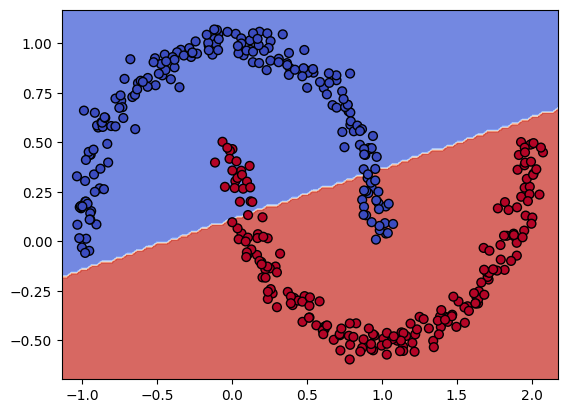

In [116]:
def plot_decision_boundary(model,X,y):

  # Grid of points. Minmax values here makes the plot range constrict.
  # 100 Points for linspace makes the contourn sharper.
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Predict the decision points based on the model we have trained beforeha
  grid_points = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(grid_points)

  # Round the values for having a clear binary contourn. Reshape to plot
  # from (1000,1) to (100,100)

  contourn_prediction = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)
  binary_prediction = np.where(contourn_prediction > 0, 1, 0)

  # Plot decision boundary
  plt.contourf(xx, yy, binary_prediction, cmap=plt.cm.coolwarm , alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40,edgecolor='k', cmap=plt.cm.coolwarm)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  return binary_prediction

contourn_prediction = plot_decision_boundary(model_1,train_features,train_label)
np.unique(contourn_prediction)

## Creating a multilayered classification model

In [117]:
# Multi-layered model 2

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_2 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(1)]
)

# 2. Compile the model.

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model.

history2 = model_2.fit(train_features, train_label, epochs=100, verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1871 - loss: 12.1393 
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3342 - loss: 9.3857 
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5092 - loss: 7.9230
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5092 - loss: 7.9178
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 7.9152
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5083 - loss: 7.9277
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 7.9126
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5092 - loss: 7.9120
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 7.9115
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5082 - loss: 7.9273
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 7.9112
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accura

In [118]:
history_table_2 = build_hist_table(history2)
history_table_2.tail()

,accuracy,loss,epoch
95,0.4975,8.099343,95
96,0.4975,8.099343,96
97,0.4975,8.099343,97
98,0.4975,8.099343,98
99,0.4975,8.099343,99


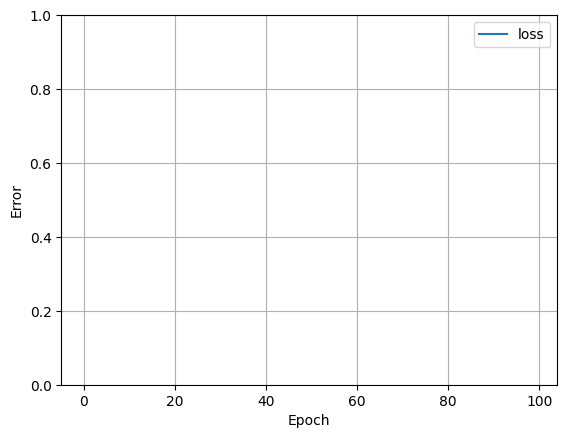

In [119]:
plot_loss(history2,[0,1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


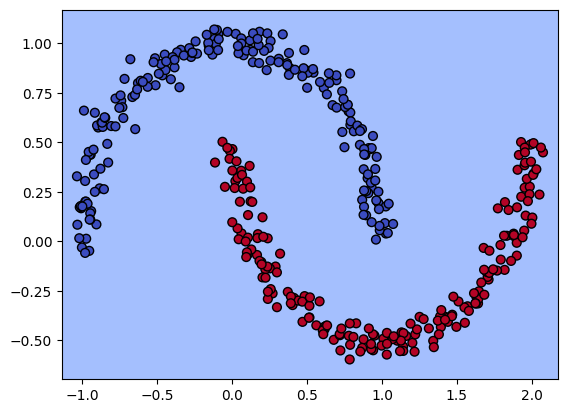

In [120]:
contourn_prediction=plot_decision_boundary(model_2,train_features,train_label)

## Optimizing our multilayered model

We can create a model that can perform better if we try to use an activation function that is not the default linear activation for our neurons. As we can see with the decision boundary, this could help to develop a classification decision that could have more complex patterns.

In [121]:
# Multi-layered model 3, with specific defined activation functions

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_3 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(5,activation=tf.keras.activations.relu),
     tf.keras.layers.Dense(5,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)]
)

# 2. Compile the model.

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fit the model.

history3 = model_3.fit(train_features, train_label, epochs=100, verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4305 - loss: 0.7636
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4064 - loss: 0.7280
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4561 - loss: 0.6986
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5216 - loss: 0.6743
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6452 - loss: 0.6541
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6982 - loss: 0.6373
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7259 - loss: 0.6224
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7371 - loss: 0.6089
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7431 - loss: 0.5969
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7448 - loss: 0.5854
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7585 - loss: 0.5743
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

In [122]:
history_table_3 = build_hist_table(history3)
history_table_3.tail()

,accuracy,loss,epoch
95,0.8825,0.248969,95
96,0.8825,0.247915,96
97,0.8825,0.246886,97
98,0.8825,0.245881,98
99,0.8825,0.244891,99


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([0, 1])

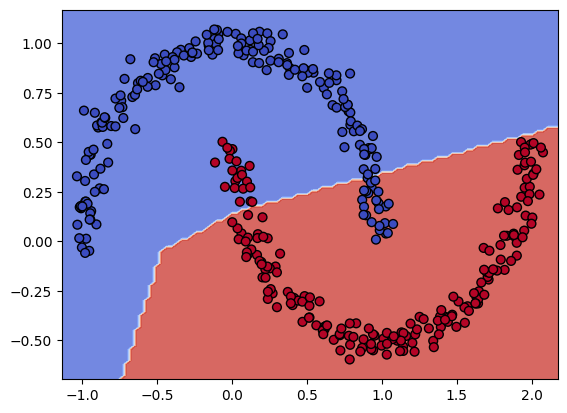

In [123]:
contourn_prediction=plot_decision_boundary(model_3,train_features,train_label)
np.unique(contourn_prediction)

We can already see the improvement, but let's see how it performs with more epochs.

In [124]:
history4 = model_3.fit(train_features, train_label, epochs=100, verbose=1)
history_table_4 = build_hist_table(history4)
history_table_4.tail()

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2373
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.2361
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.2350
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2340
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8823 - loss: 0.2320
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8823 - loss: 0.2311
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2312
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2303
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8834 - loss: 0.2295
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.2287
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8823 - loss: 0.2269
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

,accuracy,loss,epoch
95,0.8775,0.220157,95
96,0.8775,0.220120,96
97,0.8775,0.220084,97
98,0.8775,0.220049,98
99,0.8775,0.220015,99


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step


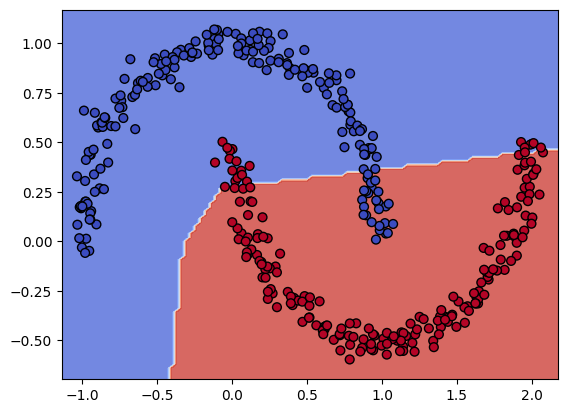

In [125]:
contourn_prediction=plot_decision_boundary(model_3,train_features,train_label)

These results are starting to look solid and the classification seem to resemble the shape of the data.

Activation function as we have seen, has a direct impact on how the weights and the accuracy is determined for our model. Therefore, I think our dataset has some hyperbolic features, so we could try to use a hyperbolic function to train the model and see how it performs.

In [126]:
# Multi-layered model 4, with specific defined activation functions

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_4 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(4,activation=tf.keras.activations.tanh),
     tf.keras.layers.Dense(4,activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)]
)

# 2. Compile the model.

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fit the model.

history4 = model_4.fit(train_features, train_label, epochs=200, verbose=1)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8097 - loss: 0.5353
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8167 - loss: 0.5227
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8140 - loss: 0.5112
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8183 - loss: 0.4993
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8118 - loss: 0.4898
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8137 - loss: 0.4798
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8215 - loss: 0.4701
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8305 - loss: 0.4607
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8305 - loss: 0.4518
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8355 - loss: 0.4431
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8355 - loss: 0.4348
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


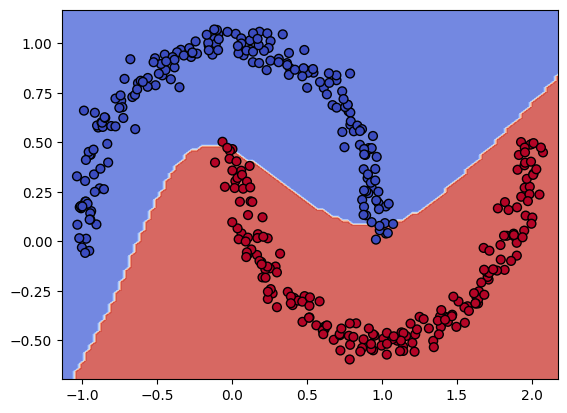

In [127]:
contourn_prediction=plot_decision_boundary(model_4,train_features,train_label)

Text(0.5, 1.0, 'Model_4 training curves')

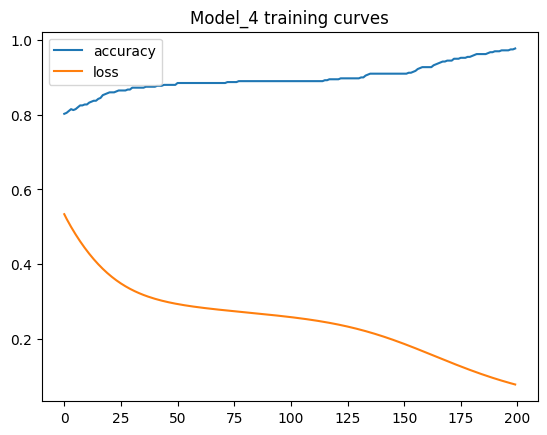

In [128]:
pd.DataFrame(history4.history).plot()
plt.title("Model_4 training curves")

Text(0.5, 1.0, 'Model_3 training curves')

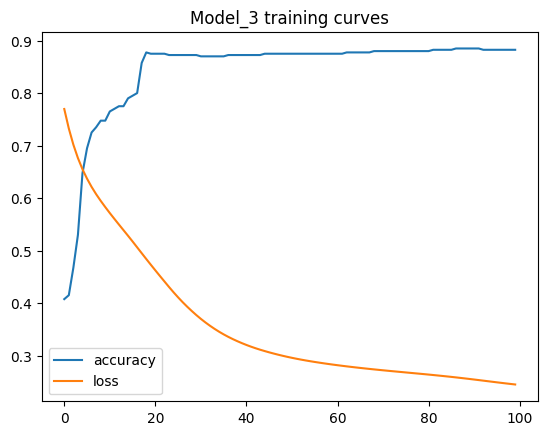

In [129]:
pd.DataFrame(history3.history).plot()
plt.title("Model_3 training curves")

In [130]:
print("model 2 evaluation",model_2.evaluate(test_features,test_label))
print("model 3 evaluation",model_3.evaluate(test_features,test_label))
print("model 4 evaluation",model_4.evaluate(test_features,test_label))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5290 - loss: 7.5916
model 2 evaluation [7.897866725921631, 0.5099999904632568]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.1915  
model 3 evaluation [0.18829627335071564, 0.8999999761581421]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9632 - loss: 0.0766
model 4 evaluation [0.0784790888428688, 0.9599999785423279]


We can agree this results are impecable already, and we could still improve the efficiency by modifying our learning rate and decreasing the number of epochs, reaching the optimal weights sooner. Let's try and compare then again the training curves.

In [131]:
# Multi-layered model 5, with specific defined activation functions and efficient learning rates.

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_5 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(4,activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)]
)

# 2. Compile the model.

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                metrics=['accuracy'])

# 3. Fit the model.

history5 = model_5.fit(train_features, train_label, epochs=30, verbose=1)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4661 - loss: 0.7449
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.3199
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8808 - loss: 0.2637
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8821 - loss: 0.2420
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8899 - loss: 0.2194
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9129 - loss: 0.1866
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9517 - loss: 0.1488
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 0.1113
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9774 - loss: 0.0801
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0574
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0415
Epoch 12/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - lo

Text(0.5, 1.0, 'Model_5 training curves')

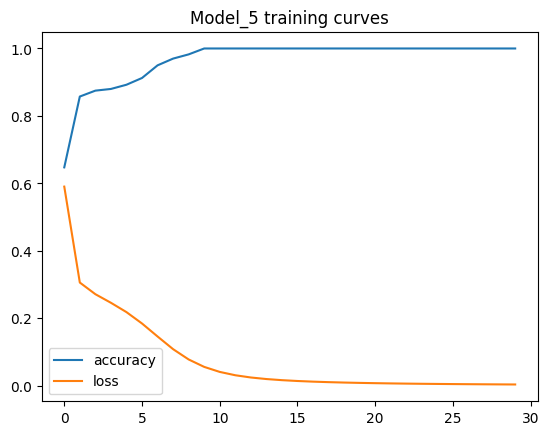

In [132]:
pd.DataFrame(history5.history).plot()
plt.title("Model_5 training curves")

In [133]:
print("model 2 evaluation",model_2.evaluate(test_features,test_label))
print("model 3 evaluation",model_3.evaluate(test_features,test_label))
print("model 4 evaluation",model_4.evaluate(test_features,test_label))
print("model 5 evaluation",model_5.evaluate(test_features,test_label))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5290 - loss: 7.5916
model 2 evaluation [7.897866725921631, 0.5099999904632568]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8954 - loss: 0.1915
model 3 evaluation [0.18829627335071564, 0.8999999761581421]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9632 - loss: 0.0766
model 4 evaluation [0.0784790888428688, 0.9599999785423279]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0036
model 5 evaluation [0.003783681197091937, 1.0]


What could still be the most efficient learning rate to use? We can try to use callbacks to determine what learning rate would be the most optimal for our model.

In [145]:
# Model with callback to explore what learning rate could be optimal.

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_6 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(4,activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)]
)

# 2. Compile the model.

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Creating a learning rate callback

# Create a learning rate scheduler callback
learningrate_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * (10*(epoch))) 

# 3. Fit the model.

history6 = model_6.fit(train_features, train_label, epochs=100, callbacks=learningrate_scheduler)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5540 - loss: 0.8303 - learning_rate: 0.0000e+00
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5541 - loss: 0.8258 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5378 - loss: 0.8026 - learning_rate: 0.0020
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5335 - loss: 0.7644 - learning_rate: 0.0030
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5356 - loss: 0.7173 - learning_rate: 0.0040
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5405 - loss: 0.6679 - learning_rate: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5604 - loss: 0.6208 - learning_rate: 0.0060
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6176 - loss: 0.5777 - learning_rate: 0.0070
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6593 - loss: 0.5378 - learning_rate: 0.0080
Epoch 10/100
13

Now we can try to visualize what is the point where the loss has reached a minimun related to the value of the changing learning rate.

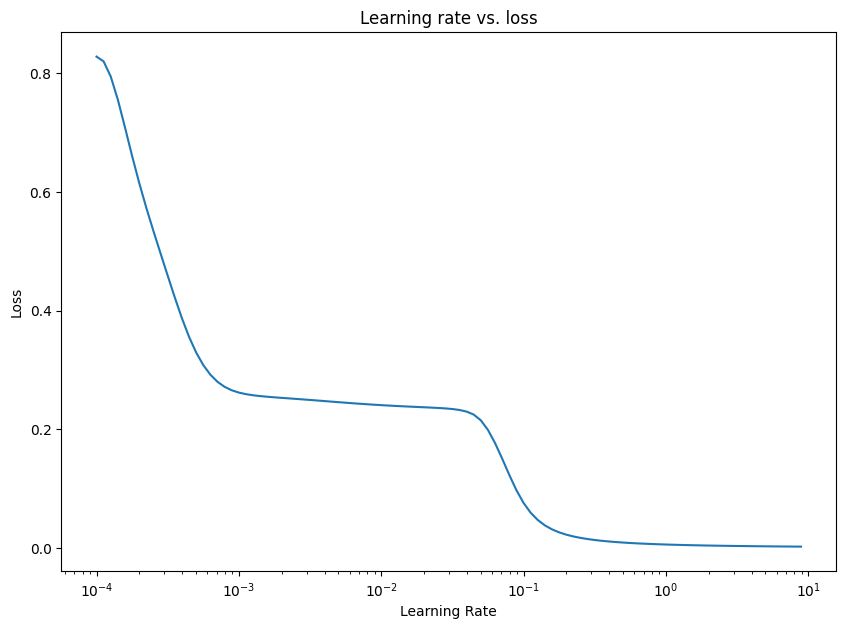

In [146]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history6.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [136]:
minpos = np.argmin(history6.history["loss"])
print("the min loss is ",np.min(history6.history["loss"]),
      " and the learning rate that achieves it is",lrs[minpos])


the min loss is  0.00013151760504115373  and the learning rate that achieves it is 8.91250938133746


Despite checking the continuous improval of the loss wit the learning rate, we only need to use the first minimum that can make our model work efficiently, so a value close to 0.02

In [147]:
# Model with callback to explore what learning rate could be optimal.

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_7 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(4,activation=tf.keras.activations.tanh),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)]
)

# 2. Compile the model.

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=(0.99*(10**-1))),
                metrics=['accuracy'])

# 3. Fit the model.

history7 = model_7.fit(train_features, train_label, epochs=30)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7751 - loss: 0.4986
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8673 - loss: 0.3029
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.2674
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8814 - loss: 0.2636
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.2610
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.2582
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.2556
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.2533
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8828 - loss: 0.2516
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8828 - loss: 0.2499
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.2484
Epoch 12/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8836 - lo

Text(0.5, 1.0, 'Model_7 training curves')

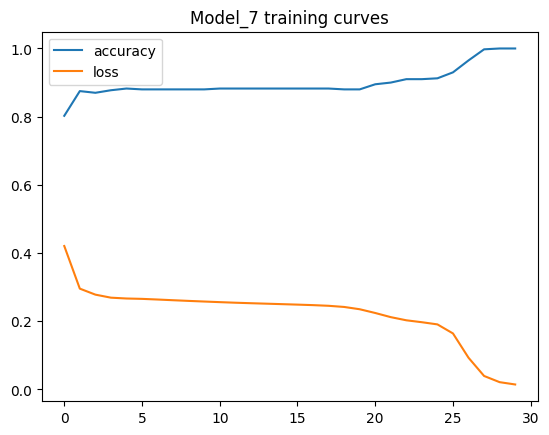

In [148]:
pd.DataFrame(history7.history).plot()
plt.title("Model_7 training curves")

Here concludes the first part of training our model for binary classification problems.